In [1]:
%reset
import sys, os
import pickle as pk
import numpy as np
import matplotlib.pyplot as pl
import matplotlib
%matplotlib inline
# gpuid = 0
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_LAUNCH_BLOCKING"]="1"
# os.environ['CUDA_VISIBLE_DEVICES']=str(gpuid)
import torch
dev = torch.device("cuda")
# torch.cuda.set_device(dev)
import torch.optim as optim
from torch.distributions import MultivariateNormal
from torch.distributions import Normal
# change the root directory for this notebook
root_dir = '/global/cfs/cdirs/lsst/www/shivamp/AR_NPE/'
os.chdir(root_dir)

import sys, os
from nf.combined_models import COMBINED_Model
from nf.all_models import *


%load_ext autoreload
%autoreload 2




Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [2]:
ji = 0
ns_d=256
nb = 8
nax = ns_d//nb
nf = 3
nc = 3
# z=127 is the initial condition
z_all = [0, 0.5, 127]
# open the density files for each z and stack along the 2nd axis
df_d0 = np.load('/pscratch/sd/s/spandey/quijote/Snapshot_fid/Snapshot_fid_density/' + str(ji) + '/df_m_' + str(ns_d) + '_nbatch=' + str(nb) + '_nfilter=' + str(nf) + '_ncnn=' + str(nc) + '_CIC_z=0_subvol.npy')
df_d_all = np.zeros((df_d0.shape[0], len(z_all), df_d0.shape[1], df_d0.shape[2], df_d0.shape[3]))
for iz, z in enumerate(z_all):
    df_d_all[:, iz, ...] = np.load('/pscratch/sd/s/spandey/quijote/Snapshot_fid/Snapshot_fid_density/0/df_m_' + str(ns_d) + '_nbatch=' + str(nb) + '_nfilter=' + str(nf) + '_ncnn=' + str(nc) + '_CIC_z=' + str(z) + '_subvol.npy')

# open the halo information files. These can have a different nside
ns_h = 128
df_h = pk.load(open('/pscratch/sd/s/spandey/quijote/Snapshot_fid/Snapshot_fid_density/' + str(ji) + '/halo_data_dict_' + str(ns_h) + '.pk','rb'))
# This has information on the halo mass for all the halos in the voxel
df_Mh_all = df_h['M_halos']
# This has information on the number of halos in the voxel
df_Nh = df_h['N_halos']

# print(df_Mh_all.shape, df_Nh.shape, df_d_all.shape)
nsims = 128
df_Mh_all = df_Mh_all[:nsims,...]
df_Nh = df_Nh[:nsims,...]
df_d_all = df_d_all[:nsims,...]




In [3]:
# Now we reshape the number of halos into 2D array of shape number of sub-sim, nvoxels (per sub-sim)
# Note that the number of sub-sim = nb**3
N_halos_all = df_Nh.reshape((df_Nh.shape[0], df_Nh.shape[1]*df_Nh.shape[2]*df_Nh.shape[3]))

# Do the same for the halo mass
M_halos_all = df_Mh_all.reshape((df_Mh_all.shape[0], df_Mh_all.shape[1]*df_Mh_all.shape[2]*df_Mh_all.shape[3], df_Mh_all.shape[4]))

# Sort the halo mass in descending order
M_halos_all_sort = np.flip(np.sort(M_halos_all, axis=-1), axis=-1)
# Scale the halo masses to be between 0 and 1
Mmin, Mmax = 13.1, 16.0
M_halos_all_sort_norm = (M_halos_all_sort - Mmin) / (Mmax - Mmin)

# If the halo mass is negative, set it to some small value close to zero
ind_neg = np.where(M_halos_all_sort_norm < 0)
M_halos_all_sort_norm[ind_neg] = 1e-4




In [4]:
# M_halos_all_sort_norm = M_halos_all_sort_norm[:,:,:4]
# M_halos_all_sort_norm.shape


In [5]:
# This creates a mask for the halo mass matrix. The mask is 1 in the last axis corresponding to number of halos in that voxel
mask_all = np.zeros((N_halos_all.shape[0], N_halos_all.shape[1], M_halos_all_sort.shape[-1]))
idx = np.arange(M_halos_all_sort.shape[-1])[None,None,:]
mask_all[np.arange(N_halos_all.shape[0])[:,None,None], np.arange(N_halos_all.shape[1])[None,:,None], idx] = (idx < N_halos_all[...,None])

# Also create a mask for mass difference. This is 1 if the halo more than one halo is present and 0 if it is not
N_halos_diff = N_halos_all - 1
N_halos_diff[N_halos_diff < 0] = 0
mask_M_diff = np.zeros((N_halos_all.shape[0], N_halos_all.shape[1], M_halos_all_sort_norm.shape[-1]-1))
idx = np.arange(M_halos_all_sort_norm.shape[-1]-1)[None,None,:]
mask_M_diff[np.arange(N_halos_all.shape[0])[:,None,None], np.arange(N_halos_all.shape[1])[None,:,None], idx] = (idx < N_halos_diff[...,None])

mask_M1 = mask_all[:, :, 0]


In [6]:
# Heavist halo mass in each voxel
M1_halos_all_norm = M_halos_all_sort_norm[..., 0]

# Take the rest of the halo masses and create a diff array
M_diff_halos_all_norm = M_halos_all_sort_norm[..., :-1] - M_halos_all_sort_norm[..., 1:]
# M_diff_halos_all_norm = M_halos_all_sort_norm[..., 1:]

# Now we create a mask for the halo masses. This is needed for the loss function
M_diff_halos_all_norm_masked = M_diff_halos_all_norm * mask_M_diff

print(N_halos_all.shape, M1_halos_all_norm.shape, M_diff_halos_all_norm_masked.shape)



(128, 4096) (128, 4096) (128, 4096, 9)


In [23]:
# pl.figure()
# _ = pl.hist(M_diff_halos_all_norm[:,0])
# print(mask_M1.shape, nax, df_d_all.shape, df_Nh.shape)
# (128//8)**3
# N_halos_all.shape
Nhalo_train_mg.shape



(128, 4096)

In [40]:
Nmax = int(np.amax(N_halos_all))
mu_all = np.arange(Nmax + 1) + 1
sig_all = 0.05 * np.ones_like(mu_all)
Nhalo_train_mg = sig_all[0] * np.random.randn(N_halos_all.shape[0], N_halos_all.shape[1]) + (N_halos_all) + 1
Nhalo_train_mg_arr = Nhalo_train_mg[...,np.newaxis]
ngauss_Nhalo = Nmax + 1

print(Nhalo_train_mg.shape, Nhalo_train_mg_arr.shape)



(128, 4096) (128, 4096, 1)


In [41]:
hidden_dim_MAF = 5
learning_rate = 0.01
nflows_M1_NSF = 5
ngauss_M1 = 5
changelr = False
ksize = nf
ninp = df_d_all.shape[1]
nfeature_cnn = 4
nout_cnn = 4*nfeature_cnn
# num_cond = nout_cnn + ninp
num_cond = nout_cnn






In [42]:
# rand_mat = np.random.rand(100,100)
# # rand_mat.shape
# np.pad(rand_mat, 0, 'wrap').shape



In [43]:
model_Ntot = SumGaussModel(
    hidden_dim=hidden_dim_MAF,
    num_cond=num_cond,
    ngauss=ngauss_Nhalo,
    mu_all=mu_all,
    sig_all=sig_all
    )
model_Ntot.to(dev)
model_parameters = filter(lambda p: p.requires_grad, model_Ntot.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)



169


In [47]:
model_M1 = NSF_M1_CNNcond(K=5, B=3, 
                       hidden_dim = hidden_dim_MAF,
                       num_cond=num_cond+1,nflows=nflows_M1_NSF,
                      base_dist="gumbel", mu_pos=False)    

model_M1.to(dev)
model_parameters = filter(lambda p: p.requires_grad, model_M1.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)



1166


In [48]:
M_diff_halos_all_norm_masked.shape


(128, 4096, 9)

In [49]:
# nflow = 3
nflows_Mdiff_NSF = 6
nsim, nvox_b, ndim_diff= M_diff_halos_all_norm_masked.shape[0], M_diff_halos_all_norm_masked.shape[1], M_diff_halos_all_norm_masked.shape[2]
# base_dist = 'halfgauss'
base_dist = 'gumbel'
# base_dist = 'weibull'
model_Mdiff = NSF_Mdiff_CNNcond(dim=ndim_diff,K=5, B=3, 
                       hidden_dim = hidden_dim_MAF,
                       num_cond=num_cond+2,nflows=nflows_Mdiff_NSF,
                      base_dist=base_dist, mu_pos=True)    
model_Mdiff.to(dev)
model_parameters = filter(lambda p: p.requires_grad, model_Mdiff.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)





# flows_Mdiff = []
# for _ in range(nflow):
#     flow_ji = MAF_CNN_cond(dim=ndim_diff, hidden_dim=hidden_dim_MAF, num_cond=num_cond + 2)
#     flow_ji.to(dev)
#     flows_Mdiff.append(flow_ji)
    
# # prior = MultivariateNormal(torch.zeros(ndim_diff), torch.eye(ndim_diff))
# # prior = prior.to('cuda')
# priors_all = []
# for _ in range(ndim_diff):
#     norm_ji = Normal(torch.tensor([0.0], device='cuda'), torch.tensor([1.0], device='cuda'))
#     # norm_ji = norm_ji.to('cuda')
#     priors_all.append(norm_ji)




13793


In [50]:
# num_cond+2
# ndim_diff
# model_Mdiff.layers_all_dim
# df_Mh_all.shape
# df_Mh_all.shape[-1]
# nsim, nvox_b, ndim_diff
# 11072 + 328+554+119
# model_Mdiff



In [51]:
ndim = ndim_diff+1
model = COMBINED_Model(
        # priors_all,
        None,
        # flows_Mdiff,
        model_Mdiff,
        # None,
        model_M1,
        # None,
        model_Ntot,
        ndim,
        ksize,
        ns_d,
        ns_h,
        nb,
        ninp,
        nfeature_cnn,
        nout_cnn,
        # layers_types=['cnn', 'res', 'res', 'res'],
        # layers_types=['cnn', 'res'],    
        layers_types=['cnn', 'res'],    
        act='tanh',
        padding='valid',
        sep_Ntot_cond=True,
        sep_M1_cond=True,
        sep_Mdiff_cond=True,
        train_Ntot=True,
        train_M1=True,
        train_Mdiff=True
    )

model.to(dev)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_all_it = []
loss_min = 1e20



In [52]:
# list(model.parameters())
# model.conv_layers


In [53]:
# ninp 
# len(priors_all)
# print(next(model.parameters()).is_cuda)
# model.conv_layers
model_parameters = filter(lambda p: p.requires_grad, model.conv_layers.parameters())
params_cnn = sum([np.prod(p.size()) for p in model_parameters])
print(params_cnn)

model_parameters = filter(lambda p: p.requires_grad, model_Mdiff.parameters())
params_Mdiff = sum([np.prod(p.size()) for p in model_parameters])
print(params_Mdiff)

model_parameters = filter(lambda p: p.requires_grad, model_M1.parameters())
params_M1 = sum([np.prod(p.size()) for p in model_parameters])
print(params_M1)

model_parameters = filter(lambda p: p.requires_grad, model_Ntot.parameters())
params_Ntot = sum([np.prod(p.size()) for p in model_parameters])
print(params_Ntot)


print(params_cnn + params_Mdiff + params_M1 + params_Ntot)



15168
13793
1166
169
30296


In [54]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)





33056


In [55]:
(Nhalo_train_mg_arr.reshape(Nhalo_train_mg_arr.shape[0]*Nhalo_train_mg_arr.shape[1], 1)).shape



(524288, 1)

In [56]:
# cond_tensor.to('cuda')
# # dev
# cond_tensor.device

# # cond_tensor.get_device()



In [64]:
# torch.amin(X_Mdiff)
# mask_M1.shape, mask_M_diff.shape, M1_halos_all_norm.shape, M1_halos_all_norm.shape, Nhalo_train_mg_arr.shape
M_diff_halos_all_norm_masked.shape



(128, 4096, 9)

In [379]:
from tqdm import tqdm
ninit = 0
niterations = 2000
for g in optimizer.param_groups:
    g['lr'] = 0.000075
for ito in tqdm(range(niterations)):
    optimizer.zero_grad()
    it = ito + ninit
    # ind_all = np.arange(density_train.shape[0])
    # indsel_rand = ind_all
    # density_tensor = torch.Tensor(np.array(np.copy(density_train[indsel_rand])))
    # cond_tensor = density_tensor
    cond_tensor = torch.Tensor(df_d_all)
    mask_tensor_M1_train = torch.Tensor(np.copy(mask_M1.reshape(mask_M1.shape[0]*mask_M1.shape[1])))
    # mask_tensor_Nhalo_train = torch.Tensor(np.copy(mask_Nhalo_train[indsel_rand, :]))
    mask_tensor_Mdiff_train = torch.Tensor(np.copy(mask_M_diff.reshape(mask_M_diff.shape[0]*mask_M_diff.shape[1], mask_M_diff.shape[2])))

    # print(N_halos_all.shape, M1_halos_all_norm.shape, M_diff_halos_all_norm_masked.shape)
    X_M1 = torch.Tensor(np.copy(M1_halos_all_norm.reshape(M1_halos_all_norm.shape[0]*M1_halos_all_norm.shape[1], 1)))
    X_Nhalo = torch.Tensor(np.copy((Nhalo_train_mg_arr.reshape(Nhalo_train_mg_arr.shape[0]*Nhalo_train_mg_arr.shape[1], Nhalo_train_mg_arr.shape[2]))))
    X_Mdiff = torch.Tensor(np.copy(M_diff_halos_all_norm_masked.reshape(mask_M_diff.shape[0]*mask_M_diff.shape[1], mask_M_diff.shape[2])))
    X_M1 = X_M1.to(dev)
    X_Nhalo = X_Nhalo.to(dev)
    X_Mdiff = X_Mdiff.to(dev)
    cond_tensor = cond_tensor.to(dev)
    mask_tensor_Mdiff_train = mask_tensor_Mdiff_train.to(dev)
    mask_tensor_M1_train = mask_tensor_M1_train.to(dev)
    loss = model(
        X_Mdiff,
        X_M1,
        X_Nhalo,
        cond_x=cond_tensor,
        mask_Mdiff_truth=mask_tensor_Mdiff_train,
        mask_M1_truth=mask_tensor_M1_train,
        Nhalos_truth=torch.Tensor(np.copy((N_halos_all.reshape(N_halos_all.shape[0]*N_halos_all.shape[1], 1)))),
        use_Ntot_samples=False,
        use_M1_samples=False
        )

    loss.backward()
    optimizer.step()

    # loss_all_it.append(float(loss.detach().numpy()))

    if (np.mod(it, int(niterations / 10)) == 0) or (it == niterations - 1):
        if float(loss.cpu().detach().numpy()) < loss_min:
            loss_min = float(loss.cpu().detach().numpy())
            # print(loss1.detach().numpy(), loss2.detach().numpy(), loss3.detach().numpy())
            print('saving bf at:', ', with loss:', np.round(loss_min, 4))
            # print('saving bf at:', it, ', with loss:', np.round(loss_min, 9))
            state = {'loss_min': loss_min, 'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}

            torch.save(state, 'FINAL_COMBINED/model_save_ji' + str(ji) + '_nsd' + str(ns_d) + '_nb' + str(nb) + '_nf' + str(nf) + '_nsh' + str(ns_h) + '_nsim' + str(nsims))

            


  0%|          | 1/2000 [00:00<20:05,  1.66it/s]

saving bf at: , with loss: -1.3025


 10%|█         | 201/2000 [01:46<16:21,  1.83it/s]

saving bf at: , with loss: -1.3026


 20%|██        | 401/2000 [03:32<14:31,  1.83it/s]

saving bf at: , with loss: -1.3027


 30%|███       | 601/2000 [05:19<12:48,  1.82it/s]

saving bf at: , with loss: -1.3028


 40%|████      | 801/2000 [07:05<10:54,  1.83it/s]

saving bf at: , with loss: -1.3029


 50%|█████     | 1001/2000 [08:52<09:08,  1.82it/s]

saving bf at: , with loss: -1.3029


 67%|██████▋   | 1347/2000 [11:55<05:47,  1.88it/s]


KeyboardInterrupt: 

In [363]:
# X_Nhalo.shape
# X_Nhalo.shape, X_M1.shape, mask_M1.shape
# mask_tensor_M1_train.shape
# mask_tensor_Mdiff_train.shape, X_Mdiff.shape
loss
# mask_tensor_Mdiff_tr?ain






tensor(-1.3024, device='cuda:0', grad_fn=<MeanBackward0>)

In [364]:
# X_Mdiff
cond_tensor.shape



torch.Size([128, 3, 38, 38, 38])

In [365]:
cond_tensor = cond_tensor.to(dev)
Ntot_samp, M1_samp, M_diff_samp, mask_tensor_M1_samp, mask_tensor_Mdiff_samp = model.inverse(
        cond_x=cond_tensor,
        use_truth_Nhalo=False,
            use_truth_M1=False,
            use_truth_Mdiff=False,
            mask_Mdiff_truth=mask_tensor_Mdiff_train,
            mask_M1_truth=mask_tensor_M1_train,
            Nhalos_truth=X_Nhalo,
            M1_truth=X_M1
        )





tensor([0.3705, 0.3580, 0.3665,  ..., 0.0246, 0.0253, 0.0272], device='cuda:0',
       grad_fn=<DivBackward0>) tensor([0.5033, 0.4901, 0.5115,  ..., 0.1293, 0.1306, 0.1319], device='cuda:0',
       grad_fn=<ExpBackward>)
tensor([0.2494, 0.2462, 0.2449,  ..., 0.2431, 0.2401, 0.2484], device='cuda:0',
       grad_fn=<DivBackward0>) tensor([0.1817, 0.1755, 0.1738,  ..., 0.1792, 0.1711, 0.1908], device='cuda:0',
       grad_fn=<ExpBackward>)
tensor([0.6643, 0.6666, 0.6717,  ..., 0.6161, 0.6147, 0.6381], device='cuda:0',
       grad_fn=<DivBackward0>) tensor([0.9549, 0.8352, 0.6512,  ..., 0.0712, 0.0829, 0.0706], device='cuda:0',
       grad_fn=<ExpBackward>)
tensor([0.3017, 0.3043, 0.3032,  ..., 0.2804, 0.2767, 0.2954], device='cuda:0',
       grad_fn=<DivBackward0>) tensor([0.0140, 0.0152, 0.0145,  ..., 0.6062, 1.2693, 0.2468], device='cuda:0',
       grad_fn=<ExpBackward>)
tensor([0.2755, 0.2761, 0.2758,  ..., 0.3718, 0.3812, 0.4035], device='cuda:0',
       grad_fn=<DivBackward0>) tenso

In [366]:
Ntot_samp.shape, X_Nhalo[:,0].cpu().detach().numpy().shape


((524288,), (524288,))

In [367]:
M1_samp.shape, X_M1[:,0].cpu().detach().numpy().shape


(torch.Size([524288]), (524288,))

In [368]:
M_diff_samp.cpu().detach().numpy().shape, X_Mdiff.cpu().detach().numpy().shape


((524288, 9), (524288, 9))

Text(0, 0.5, 'Histogram')

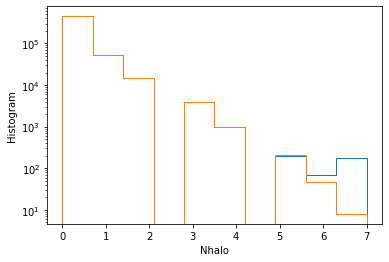

In [369]:
pl.figure()
_ = pl.hist(Ntot_samp, histtype='step')
_ = pl.hist(N_halos_all.reshape(N_halos_all.shape[0]*N_halos_all.shape[1]), histtype='step')
# _ = pl.hist(X_Nhalo[:,0].cpu().detach().numpy())
pl.yscale('log')
pl.xlabel('Nhalo')
pl.ylabel('Histogram')



In [370]:
# N_halos_all
Ntot_samp


array([0, 0, 0, ..., 7, 7, 7])

Text(0, 0.5, 'Histogram')

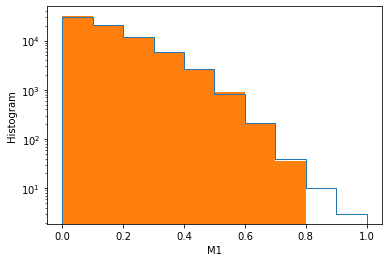

In [371]:
pl.figure()
indp = (mask_tensor_M1_samp.cpu().detach().numpy()[:,0] > 0)
_ = pl.hist(M1_samp.cpu().detach().numpy()[indp], range=(0,1), histtype='step')
indp = (mask_tensor_M1_train.cpu().detach().numpy() > 0)
_ = pl.hist(X_M1[:,0].cpu().detach().numpy()[indp], range=(0,1))
pl.yscale('log')
pl.xlabel('M1')
pl.ylabel('Histogram')




In [372]:
# M_diff_samp.shape
mask_tensor_M1_samp.shape


torch.Size([524288, 1])

Text(0, 0.5, 'Histogram')

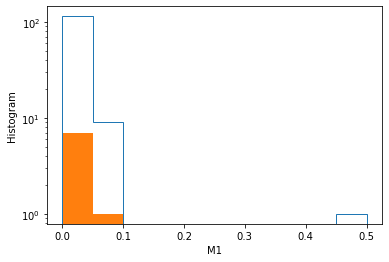

In [378]:
pl.figure()
ind_M = 5

indp = mask_tensor_Mdiff_samp[:, ind_M] > 0
_ = pl.hist(M_diff_samp[indp,ind_M].cpu().detach().numpy(), range=(0,0.5), histtype='step')
indp = mask_tensor_Mdiff_train[:, ind_M] > 0
_ = pl.hist(X_Mdiff[indp,ind_M].cpu().detach().numpy(), range=(0,0.5))


# _ = pl.hist(M_diff_samp[:,ind_M].cpu().detach().numpy(), range=(0,1), histtype='step')
# _ = pl.hist(X_Mdiff[:,ind_M].cpu().detach().numpy(), range=(0,1))


pl.yscale('log')
pl.xlabel('M1')
pl.ylabel('Histogram')




In [45]:
# X_Mdiff[:,ind_M]


In [326]:
from torch.distributions import HalfNormal, Weibull, Gumbel
mu, sig = -0.5421, 0.0679
hf = Gumbel(mu, sig)
gr = hf.sample([10000])




In [350]:
gr.shape


torch.Size([10000])